In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Decalre a base using automp_base
Base = automap_base()

# reflect an existing database into a new model
Base.prepare(autoload_with=engine)

# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
# Create an inspector to start exploring the data from the tables
inspector = inspect(engine)

In [8]:
# Inspect the 'measurement' table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Inspect the 'station' table
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
last_date_str = session.query(measurement.date).order_by(measurement.date.desc()).limit(1).scalar()
last_date_str

'2017-08-23'

In [12]:
dt.date.fromisoformat(last_date_str)

datetime.date(2017, 8, 23)

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results, starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = dt.date.fromisoformat(last_date_str)
start_date =  last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(measurement.date, func.avg(measurement.prcp))\
    .filter(measurement.date >= start_date)\
    .group_by(measurement.date)\
    .all()

last_year_data

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_df = pd.DataFrame(last_year_data, columns=['Date', 'Precipitation'])
last_year_df = last_year_df.set_index('Date')


# Sort the dataframe by date
last_year_df = last_year_df.sort_values(by='Date')


In [14]:
last_year_df

,Precipitation
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


<function matplotlib.pyplot.show(close=None, block=None)>

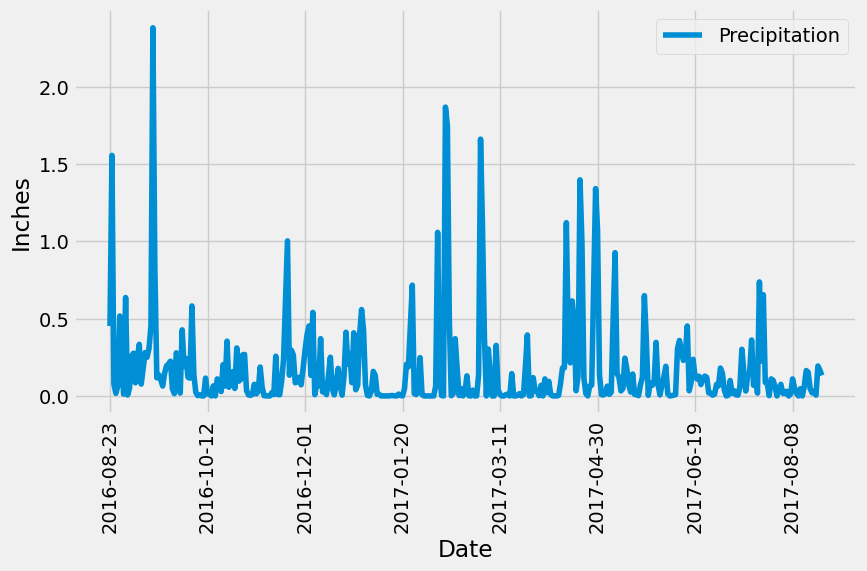

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot(xlabel='Date', ylabel='Inches', rot=90, figsize=(9,5))
plt.legend(loc = 'upper right')
plt.show

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_df.describe()

,Precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
station_number = session.query(station.id).count()
print(f'Number of Stations: {station_number}')

Number of Stations: 9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station=='USC00519281').all()
most_active_stats

[(54.0, 85.0, 71.66378066378067)]

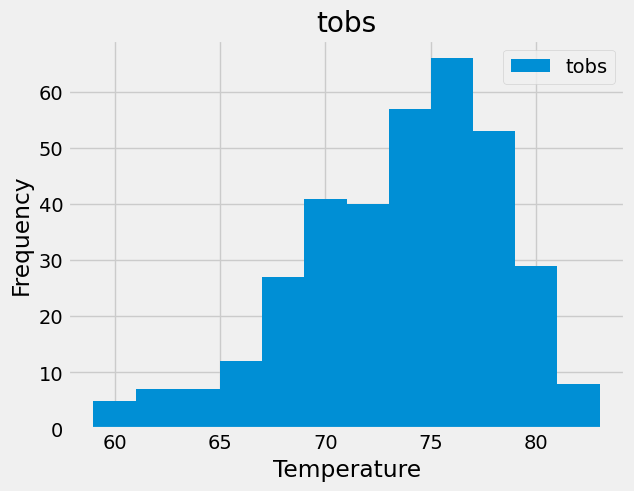

In [20]:
# Using the most active station id, query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_last_year = session.query(measurement.tobs).filter((measurement.station=='USC00519281') & (measurement.date >= start_date)).all()
pd.DataFrame(station_last_year).hist(bins=12, legend=True)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

# Close Session

In [21]:
# Close Session
session.close()